In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# fix split 
import pandas as pd
import numpy as np


# Extract training set from MNIST dataset.
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
fashion_test_df = pd.read_csv('data_copy/raw/fashion-mnist-test.csv')


np.random.seed(0)

N = len(fashion_train_df)
indices = np.random.permutation(N)  # shuffled indices, reproducible because of seed

# Calculate absolute sizes
n_train = int(0.50 * N)   # 50%
n_val = int(0.10 * N)     # 10%
n_comb = N - (n_train + n_val)  # remaining 40%

# Assign splits
idx_train = indices[:n_train]
idx_val = indices[n_train:n_train + n_val]
idx_comb = indices[n_train + n_val:]

# Get DataFrames
train_df = fashion_train_df.iloc[idx_train]
val_df = fashion_train_df.iloc[idx_val]
comb_df = fashion_train_df.iloc[idx_comb]

print('train frame: ',len(train_df))
print('validation frame: ', len(val_df))
print('combination frame: ',len(comb_df))
print('test fram; ', len(fashion_test_df))

train frame:  30000
validation frame:  6000
combination frame:  24000
test fram;  10000


In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool_1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool_1(x)

        x = F.relu(self.conv2(x))
        x = self.pool_2(x)

        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
    
model = CNN()

from torchinfo import summary
summary(model, input_size=(64, 1, 28, 28))



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [64, 8, 14, 14]           --
├─Conv2d: 1-3                            [64, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [64, 16, 7, 7]            --
├─Conv2d: 1-5                            [64, 32, 7, 7]            4,640
├─Linear: 1-6                            [64, 10]                  15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 34.22
Input size (MB): 0.20
Forward/backward pass size (MB): 5.62
Params size (MB): 0.09
Estimated Total Size (MB): 5.91

In [4]:
# Lavy function for pixel dropout 
def hide_continuous(df, hide=[0.25, 0.75], hidden_value=0):
    """
    Hides a percentage of pixels in a dataframe 
    and returns two dataframes with different masking levels.

    Args:
        df: Input dataframe
        hide (list): List of two hiding ratios
        hidden_value: The value to replace the hidden pixels with.

    Returns:
        tuple: (df_first, df_second) - Two dataframes with the specified hiddden value applied.
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    labels = df.iloc[:, 0].to_numpy()
    original_pixels = df.iloc[:, 1:].to_numpy(copy=True)  #copy to avoid modifying original df
    n_rows, n_pixels = original_pixels.shape
    
    hide_first_ratio = hide[0]
    hide_second_ratio = hide[1]

    #Calculate the number of pixels to hide for each ratio
    n_hide_first = int(n_pixels * hide_first_ratio)
    n_hide_second = int(n_pixels * hide_second_ratio)

    

    #Select indices to hide. We select the indices for the larger ratio first,
    # then use a subset of those for the smaller ratio.
    all_drop_indices = np.random.choice(
        n_pixels, 
        size=n_hide_second, 
        replace=False
    )
    
    # Indices for the smaller mask
    # Take the first n_hide_first elements of the larger set
    drop_indices_first = all_drop_indices[:n_hide_first] 
    
    # Indices for the larger mask 
    drop_indices_second = all_drop_indices 

    # first dataframe
    pixels_first = original_pixels.copy()
    # Mask rows at the selected columns
    pixels_first[:, drop_indices_first] = hidden_value 
    
    df_first = pd.DataFrame(
        pixels_first, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_first.insert(0, 'label', labels)
    
    # second dataframe
    pixels_second = original_pixels.copy()
    # Mask all rows at the selected columns
    pixels_second[:, drop_indices_second] = hidden_value
    
    df_second = pd.DataFrame(
        pixels_second, 
        columns=df.columns[1:], 
        index=df.index
    )
    df_second.insert(0, 'label', labels)
    
    return df_first, df_second

In [5]:
print(fashion_train_df.shape)
# (60000, 785)  ← first column = label, 784 pixel columns

# Call the function to get two masked versions
train_hidden15, train_hidden85 = hide_continuous(train_df, hide=[0.15, 0.85], hidden_value=0)
val_hidden15, val_hidden85 = hide_continuous(val_df, hide=[0.15, 0.85], hidden_value=0)

fashion_test_df15, fashion_test_df85 = hide_continuous(fashion_test_df, hide=[0.15, 0.85], hidden_value=0)


# Separate features (X) and labels (y) from each split
X_train = train_hidden15.drop("label", axis=1).values
y_train = train_hidden15["label"].values

X_val = val_hidden15.drop("label", axis=1).values
y_val = val_hidden15["label"].values

X_comb = comb_df.drop("label", axis=1).values
y_comb = comb_df["label"].values

# Also prepare test set from the test CSV
X_test = fashion_test_df15.drop("label", axis=1).values
y_test = fashion_test_df15["label"].values

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Combination:", X_comb.shape, y_comb.shape)
print("Test:", X_test.shape, y_test.shape)





(60000, 785)
Train: (30000, 784) (30000,)
Validation: (6000, 784) (6000,)
Combination: (24000, 784) (24000,)
Test: (10000, 784) (10000,)


In [6]:
# Convert NumPy arrays → PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders : think as a pipeline that delivers your data to the model in small, manageable pieces (batches).
batch_size = X_train.shape[0] // 20
# batch_size= 100
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
# This function is taken from deeplearning course assigment
def train_model(model, train_loader, val_loader, epochs=100, learning_rate=1e-3, patience=10):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2) # efault optimizer used in modern neural network training (used by Hugging Face, PyTorch examples, etc.).
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    start = time.perf_counter()

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 1, 28, 28)  # reshape
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(-1, 1, 28, 28)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * correct / total)

        # ---- Early Stopping ---- 
        # This section is added by AI and is used in cases where we decide to try higher epoc number
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()  # save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)  # restore best model
                break

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]:.2f}%, "
              f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]:.2f}%")

    training_time = time.perf_counter() - start
    return train_losses, train_accs, val_losses, val_accs, training_time


In [8]:
print(batch_size)

train_losses, train_accs, val_losses, val_accs, training_time = train_model(
    model, train_loader, val_loader,
    epochs=100,         
    learning_rate=1e-4,  # safe for Adam
    patience=10
)


1500
Epoch 1/100: Train Loss=5.2987, Train Acc=36.92%, Val Loss=1.1181, Val Acc=59.72%
Epoch 2/100: Train Loss=0.8339, Train Acc=70.23%, Val Loss=0.6534, Val Acc=76.93%
Epoch 3/100: Train Loss=0.5677, Train Acc=79.42%, Val Loss=0.5232, Val Acc=81.65%
Epoch 4/100: Train Loss=0.4759, Train Acc=82.82%, Val Loss=0.4670, Val Acc=83.73%
Epoch 5/100: Train Loss=0.4304, Train Acc=84.40%, Val Loss=0.4462, Val Acc=84.33%
Epoch 6/100: Train Loss=0.4061, Train Acc=85.17%, Val Loss=0.4335, Val Acc=84.97%
Epoch 7/100: Train Loss=0.3878, Train Acc=85.85%, Val Loss=0.4170, Val Acc=85.73%
Epoch 8/100: Train Loss=0.3732, Train Acc=86.37%, Val Loss=0.4065, Val Acc=85.95%
Epoch 9/100: Train Loss=0.3567, Train Acc=86.92%, Val Loss=0.4022, Val Acc=85.92%
Epoch 10/100: Train Loss=0.3494, Train Acc=87.24%, Val Loss=0.3994, Val Acc=86.05%
Epoch 11/100: Train Loss=0.3385, Train Acc=87.71%, Val Loss=0.3874, Val Acc=86.48%
Epoch 12/100: Train Loss=0.3277, Train Acc=88.01%, Val Loss=0.3854, Val Acc=86.23%
Epoch 13

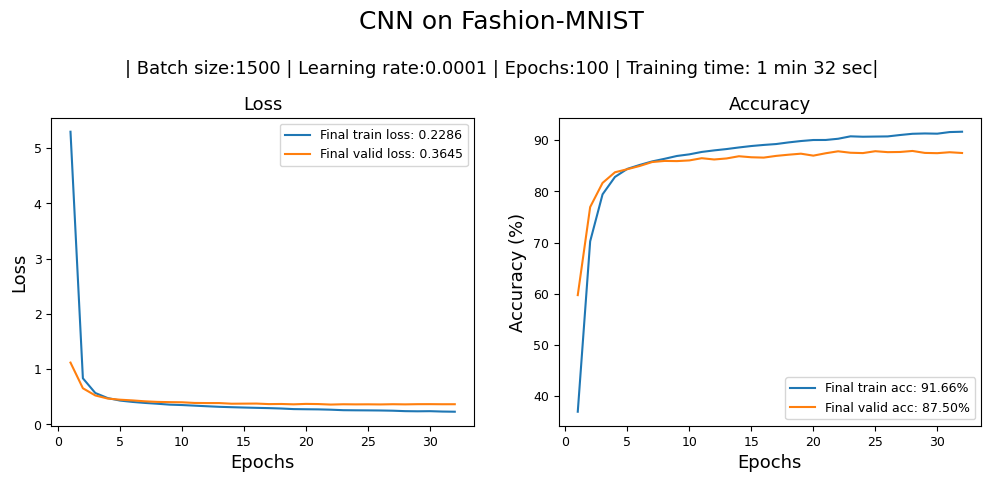

In [9]:
from matplotlib import pyplot as plt
import numpy as np

def training_curve_plot(title, train_costs, valid_costs, train_accuracies, valid_accuracies, batch_size, learning_rate, training_time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    mins, secs = divmod(training_time, 60)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Epochs:{epochs} | Training time: {int(mins)} min {secs:.0f} sec|'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)

    # ---- Loss plot ----
    axs[0].plot(x, train_costs, label=f'Final train loss: {train_costs[-1]:.4f}')
    axs[0].plot(x, valid_costs, label=f'Final valid loss: {valid_costs[-1]:.4f}')
    axs[0].set_title('Loss', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)

    # ---- Accuracy plot ----
    axs[1].plot(x, train_accuracies, label=f'Final train acc: {train_accuracies[-1]:.2f}%')
    axs[1].plot(x, valid_accuracies, label=f'Final valid acc: {valid_accuracies[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=md)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

    plt.show()

training_curve_plot(
    "CNN on Fashion-MNIST",
    train_losses,     # training loss
    val_losses,       # validation loss
    train_accs,       # training accuracy
    val_accs,         # validation accuracy
    batch_size= batch_size,
    learning_rate=1e-4,
    training_time=training_time,
    epochs=100
)


In [10]:
# Final evaluation on test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # adjust shape if needed
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 88.02%


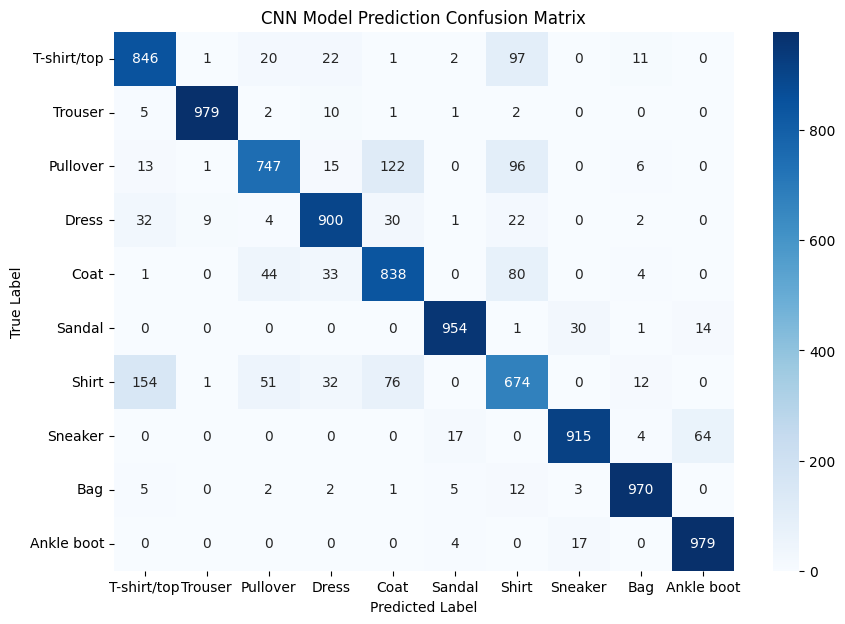

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# AI generated and taken from Deep learning assigment 
def get_predictions(model, loader, device="cpu"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # reshape if flattened
            if inputs.ndim == 2 and inputs.shape[1] == 784:
                inputs = inputs.view(-1, 1, 28, 28)
            
            outputs = model(inputs)  # logits
            _, preds = torch.max(outputs, 1)  # class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
# Testing the value with the testset 
y_true, y_pred_classes = get_predictions(model, test_loader)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Model Prediction Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [12]:
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.85      0.82      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.86      0.75      0.80      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.68      0.67      0.68      1000
     Sneaker       0.95      0.92      0.93      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.93      0.98      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [13]:
# This function is AI generated 
def show_random_predictions(test_loader, all_preds, all_labels, class_names, num_images=10):
    indices = np.random.choice(len(all_labels), num_images, replace=False)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        # Get image and true label from dataset
        image, label = test_loader.dataset[idx]
        predicted_label = all_preds[idx]

        plt.subplot(2, 5, i + 1)
        
        # If image is flattened, reshape to 28x28
        if image.ndim == 1:
            image = image.view(28, 28)
        elif image.ndim == 3:  # (1, 28, 28)
            image = image.squeeze(0)

        plt.imshow(image.cpu().numpy(), cmap="gray")
        plt.axis("off")

        # Green title if correct, red if wrong
        color = "green" if predicted_label == label else "red"
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted_label]}",
                  fontsize=10, color=color)

    plt.tight_layout()
    plt.show()


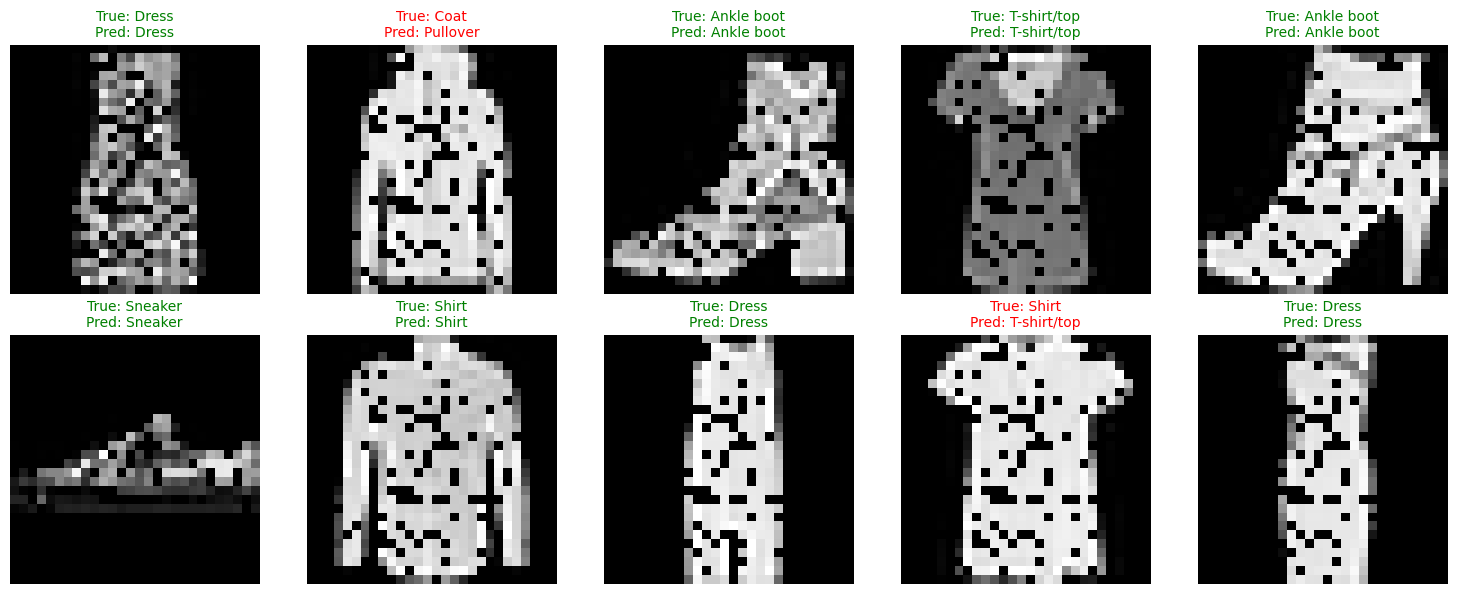

In [14]:
show_random_predictions(test_loader, y_pred_classes, y_true, class_names, num_images=10)


# Get predictions for the combine dataset 

Stratified K-fold CV on all 2400 data points. Split the combine dataset into 80% (19200) train/val and 20% (4800) into testing set. 

Use the 80% train/validation portion for meta-training with 5-fold stratified cross-validation to tune and evaluate the meta-model, then retrain it on the full 80% and evaluate once on the held-out 20% test set.

In [15]:
from sklearn.model_selection import train_test_split

# # Separate features and labels
# X_comb = comb_df.drop("label", axis=1).values
# y_comb = comb_df["label"].values

# # Split 80/20 for meta-training / meta-testing
# X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(
#     X_comb,
#     y_comb,
#     test_size=0.20,
#     stratify=y_comb,
#     random_state=0
# )

# print("Combination train:", X_comb_train.shape)
# print("Combination test:", X_comb_test.shape)


# No more split 
# The old combination of test and validation is the new the train 
X_comb_train= X_comb
y_comb_train = y_comb
# Using the orignal testset to test
X_comb_test= X_test
y_comb_test= y_test



print("Combination train:", X_comb_train.shape)
print("Combination test:", X_test.shape)

Combination train: (24000, 784)
Combination test: (10000, 784)


In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_comb_train_tensor = torch.tensor(X_comb_train, dtype=torch.float32)
y_comb_train_tensor = torch.tensor(y_comb_train, dtype=torch.long)

X_comb_test_tensor = torch.tensor(X_comb_test, dtype=torch.float32)
y_comb_test_tensor = torch.tensor(y_comb_test, dtype=torch.long)

# Datasets
comb_train_dataset = TensorDataset(X_comb_train_tensor, y_comb_train_tensor)
comb_test_dataset = TensorDataset(X_comb_test_tensor, y_comb_test_tensor)

# DataLoaders
batch_size_comb = X_comb_train.shape[0] // 20  
comb_train_loader = DataLoader(comb_train_dataset, batch_size=batch_size_comb, shuffle=False)
comb_test_loader = DataLoader(comb_test_dataset, batch_size=batch_size_comb, shuffle=False)


In [17]:
# Get predictions 
y_comb_train_true, y_comb_train_pred = get_predictions(model, comb_train_loader)
y_comb_test_true, y_comb_test_pred = get_predictions(model, comb_test_loader)


In [18]:
def predictions_probabilities(model, loader, device="cpu"):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            if inputs.ndim == 2 and inputs.shape[1] == 784:
                inputs = inputs.view(-1, 1, 28, 28)
            # Get logits
            outputs = model(inputs)     
            # Convert them into probs                
            probs = torch.softmax(outputs, dim=1)       
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)


In [19]:
# Get probability predictions
y_comb_train_true, y_comb_train_probs = predictions_probabilities(model, comb_train_loader)
y_comb_test_true,  y_comb_test_probs  = predictions_probabilities(model, comb_test_loader)


In [20]:

# Train set (combine)
cnn_train_preds_df = pd.DataFrame(
    y_comb_train_probs,
    columns=[f"CNN_class_{i}" for i in range(y_comb_train_probs.shape[1])])
cnn_train_preds_df["label"] = y_comb_train_true

# Test set (combine)
cnn_test_preds_df = pd.DataFrame(
    y_comb_test_probs,
    columns=[f"CNN_class_{i}" for i in range(y_comb_test_probs.shape[1])])
cnn_test_preds_df["label"] = y_comb_test_true


In [21]:
cnn_train_preds_df.to_csv("cnn_dropout_comb_train_predictions.csv", index=False)
cnn_test_preds_df.to_csv("cnn_dropout_comb_test_predictions.csv", index=False)

# Calibration - Ioanna 
We decided to use for calibation the method temperature scaling. Temperature scaling is a single-parameter version of Platt Logistic Scaling (Platt 1999).
https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/temp-scaling.html

https://arxiv.org/abs/1706.04599
Needs to be added after training. We need to min Negative Log Likelihood on the validation logits and find a positive scalar T, called Temperature, and use it later for the rest of the produced logits (test). The accuracy of the model will not change, we are just adjusting the probabilities.
borrowed part of the code from: 
https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py 

In [22]:
import torch
from torch import nn, optim
from torch.nn import functional as F

# Temperature scaling 
class ModelWithTemperature(nn.Module):
    """
    Pass raw logits (not softmax probs) through it
    """
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, x):
        logits = self.model(x)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        T = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / T

    def set_temperature(self, valid_loader, device="cpu"):
        """Fit temperature on validation set using Neg Log Likelihood Loss."""
        self.to(device)
        nll_criterion = nn.CrossEntropyLoss().to(device)

        # Get logits & labels
        logits_list, labels_list = [], []
        model_training = self.training
        self.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                if x.ndim == 2 and x.shape[1] == 784:
                    x = x.view(-1, 1, 28, 28)
                logits_list.append(self.model(x))
                labels_list.append(y)
        logits = torch.cat(logits_list).to(device)
        labels = torch.cat(labels_list).to(device)

        # Optimise T with respect to NLL 
        optimiser = optim.LBFGS([self.temperature], lr=0.01, max_iter=200)
        def nll_loss():
            optimiser.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimiser.step(nll_loss)
        print(f"Optimal temperature: {self.temperature.item():.2f}")
        self.train(model_training)
        return self

In [23]:
# Negative Log-Likelihood (NLL)
def compute_nll(logits, labels):
    return nn.CrossEntropyLoss()(logits, labels).item()

# Expected Calibration Error (ECE)
def compute_ece(logits, labels, n_bins=15):
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    acc = pred.eq(labels)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    ece = torch.zeros(1)
    for i in range(n_bins):
        mask = (conf > bin_boundaries[i]) & (conf <= bin_boundaries[i + 1])
        if mask.any():
            prop = mask.float().mean()
            ece = ece + torch.abs(conf[mask].mean() - acc[mask].float().mean()) * prop
    return ece.item()

In [24]:
# Get probabilities for combination train/test sets and save them as csvs
def get_probs_save(model_with_temp, data_loader, device, prefix="cnn", filename=None):
    model_with_temp.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            if x.ndim == 2 and x.shape[1] == 784:
                x = x.view(-1, 1, 28, 28)
            logits = model_with_temp.model(x)           
            scaled_logits = model_with_temp.temperature_scale(logits)
            all_logits.append(scaled_logits.cpu())
            all_labels.append(y.cpu())

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()

    ids = np.arange(len(labels))
    df = pd.DataFrame(probs, columns=[f"{prefix}_class_{i}" for i in range(probs.shape[1])])
    df.insert(0, "id", ids)
    df["true_label"] = labels.numpy()

    if filename:
        df.to_csv(filename, index=False)
        print(f"Saved {filename} ({len(df)} rows)")
    return df

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Calibrated on the validation set
scaled_model = ModelWithTemperature(model).to(device)
scaled_model.set_temperature(val_loader, device=device)

# Get calibrated probabilities for dropout CNN on comb splits
cnn_comb_train_calibrated_df = get_probs_save(
    scaled_model, 
    comb_train_loader, 
    device=device,
    prefix="cnn_dropout_cal",
    filename="cnn_dropout_comb_train_calibrated_predictions.csv")

cnn_comb_test_calibrated_df = get_probs_save(
    scaled_model, 
    comb_test_loader, 
    device=device,
    prefix="cnn_dropout_cal",
    filename="cnn_dropout_comb_test_calibrated_predictions.csv")


Optimal temperature: 1.32
Saved cnn_dropout_comb_train_calibrated_predictions.csv (24000 rows)
Saved cnn_dropout_comb_test_calibrated_predictions.csv (10000 rows)


In [26]:
# Get raw and calibrated logits 
def collect_logits(model, scaled_model, loader, device):
    raw_logits, cal_logits, labels = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if x.ndim == 2 and x.shape[1] == 784:
                x = x.view(-1, 1, 28, 28)
            out_raw = model(x)                      
            out_cal = scaled_model.temperature_scale(out_raw)  
            raw_logits.append(out_raw.cpu())
            cal_logits.append(out_cal.cpu())
            labels.append(y.cpu())
    return torch.cat(raw_logits), torch.cat(cal_logits), torch.cat(labels)

# Evaluate on the 20%
logits_raw, logits_cal, labels_comb_test = collect_logits(model, scaled_model, comb_test_loader, device)

# Accuracy shouldn't change
acc = (logits_raw.argmax(1) == labels_comb_test).float().mean().item() * 100
print(f"Combination Test Accuracy: {acc:.2f}%")

# NLL & ECE before & after calibration
print(f"NLL  before: {compute_nll(logits_raw, labels_comb_test):.4f}  "
      f"after: {compute_nll(logits_cal, labels_comb_test):.4f}")
print(f"ECE  before: {compute_ece(logits_raw, labels_comb_test):.4f}  "
      f"after: {compute_ece(logits_cal, labels_comb_test):.4f}")


Combination Test Accuracy: 88.02%
NLL  before: 0.3534  after: 0.3416
ECE  before: 0.0227  after: 0.0147


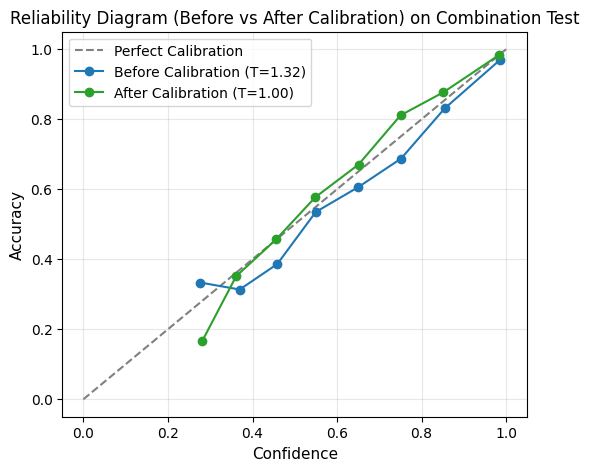

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def reliability_diagram(logits, labels, n_bins=10):
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    acc = pred.eq(labels)

    bins = torch.linspace(0, 1, n_bins + 1)
    bin_accs, bin_confs = [], []

    for i in range(n_bins):
        mask = (conf > bins[i]) & (conf <= bins[i+1])
        if mask.any():
            bin_accs.append(acc[mask].float().mean().item())
            bin_confs.append(conf[mask].mean().item())

    return np.array(bin_confs), np.array(bin_accs)

# Compute reliability bins
bin_confs_raw, bin_accs_raw = reliability_diagram(logits_raw, labels_comb_test)
bin_confs_cal, bin_accs_cal = reliability_diagram(logits_cal, labels_comb_test)

# Plot
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.plot(bin_confs_raw, bin_accs_raw, marker="o", label=f"Before Calibration (T={scaled_model.temperature.item():.2f})", color="tab:blue")
plt.plot(bin_confs_cal, bin_accs_cal, marker="o", label=f"After Calibration (T=1.00)", color="tab:green")

plt.xlabel("Confidence", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.title("Reliability Diagram (Before vs After Calibration) on Combination Test", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Accuracy remained the same as expected. Both metrices reduced showing that the model is more reliable. Because 𝑇 = 1.40 > 1
the model’s logits must be scaled down so that its probability estimates are less extreme and more aligned with reality

Rhe graph has on x-axis the predicted confidence and on the y-axis the actual accuracy. The blue line is below the perfect clibration line, acc < conf showing overconfidence. After calibrating the line is closer to the gray line which shows that is better calibrated. 

# Generate predictions on different degradation levels

In [28]:
# Degradation levels predictions will be performed on the test set
df_test = pd.DataFrame(X_comb_test)
df_test.insert(0, 'label', y_comb_test)

In [29]:
# Set manual degradation levels
degradation_levels = [0.0, 0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
degraded_datasets = {}

# Create the degraded datasets 
for level in degradation_levels:
    degraded_df, i = hide_continuous(df_test, hide=[level, level])
    degraded_datasets[level] = degraded_df


In [30]:
import torch.nn.functional as F

# Predict probabilities function to use for all degradation levels
def predict_probs(model, X, device="cpu", batch_size=256):
    model.eval()
    probs_list = []
    # No gradient 
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = torch.tensor(X[i:i+batch_size]).float().to(device)
            if batch.ndim == 3:
                batch = batch.unsqueeze(1)  
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
            probs_list.append(probs.cpu().numpy())
    
    return np.concatenate(probs_list, axis=0)


In [31]:
from sklearn.metrics import accuracy_score, log_loss
# results per dropout level for saving 
cnn_dropout_results = []

# separate data from true label 
for level, df_deg in degraded_datasets.items():
    y_true = df_deg["label"].to_numpy()
    X_deg = df_deg.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)  
    # get the probs 
    probs = predict_probs(scaled_model, X_deg, device=device)
    preds = probs.argmax(axis=1)
    # accuracy and nll 
    acc = accuracy_score(y_true, preds) * 100
    nll = log_loss(y_true, probs)
    # save the results for later plot
    cnn_dropout_results.append({
        "Degradation": level,
        "Accuracy (%)": acc,
        "NLL": nll})


    Degradation  Accuracy (%)       NLL
0           0.0         88.02  0.341553
1           0.1         88.02  0.341553
2           0.2         86.06  0.386151
3           0.3         75.36  0.712993
4           0.4         65.56  1.203042
5           0.5         48.92  2.267603
6           0.6         49.85  3.009986
7           0.7         40.08  3.280602
8           0.8         28.29  6.514780
9           0.9         18.15  7.735759
10          1.0         10.00  2.907904


C:\Users\saber\AppData\Local\Temp\ipykernel_13488\373086459.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


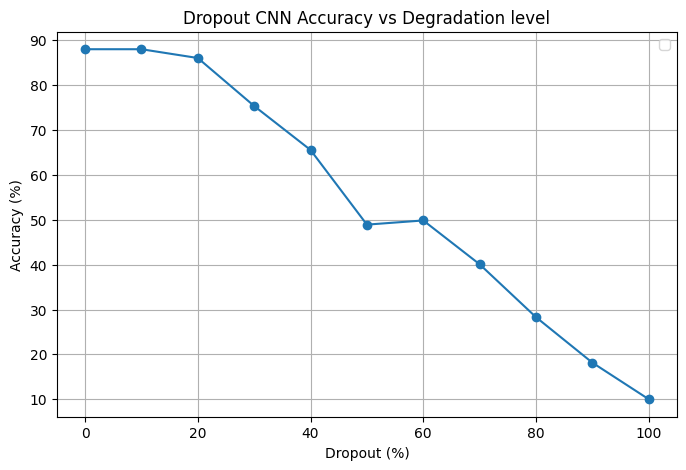

In [32]:
cnn_dropout_results_df = pd.DataFrame(cnn_dropout_results)
print(cnn_dropout_results_df)

plt.figure(figsize=(8,5))
plt.plot(cnn_dropout_results_df["Degradation"]*100, cnn_dropout_results_df["Accuracy (%)"], 'o-')
plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Dropout CNN Accuracy vs Degradation level")
plt.grid(True)
plt.legend()
plt.show()


In [33]:
for level, df_deg in degraded_datasets.items():
    y_true = df_deg["label"].to_numpy()
    X_deg = df_deg.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)
    
    probs = predict_probs(scaled_model, X_deg, device=device)
    
    preds_df = pd.DataFrame(probs, columns=[f"cnn_dropout_class_{i}" for i in range(probs.shape[1])])
    preds_df["true_label"] = y_true
    preds_df.to_csv(f"cnn_dropout_test_predictions_degradation_{int(level*100)}.csv", index=False)
